# Handwriting Recognition using K-Means

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

----
&nbsp;
### Exploring the dataset

In [3]:
data, labels = datasets.load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


The 64 features (8x8 pixels) represent the colours of an image
- `0` is white
- `16` is black
&nbsp;

The target values are digits from 0 to 9

In [4]:
digits = datasets.load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

----
&nbsp;
### Visualising a sample of the data images

There are 1797 samples in the dataset. We choose 6 at random

In [5]:
random_list = np.random.randint(0, 1796, 6)

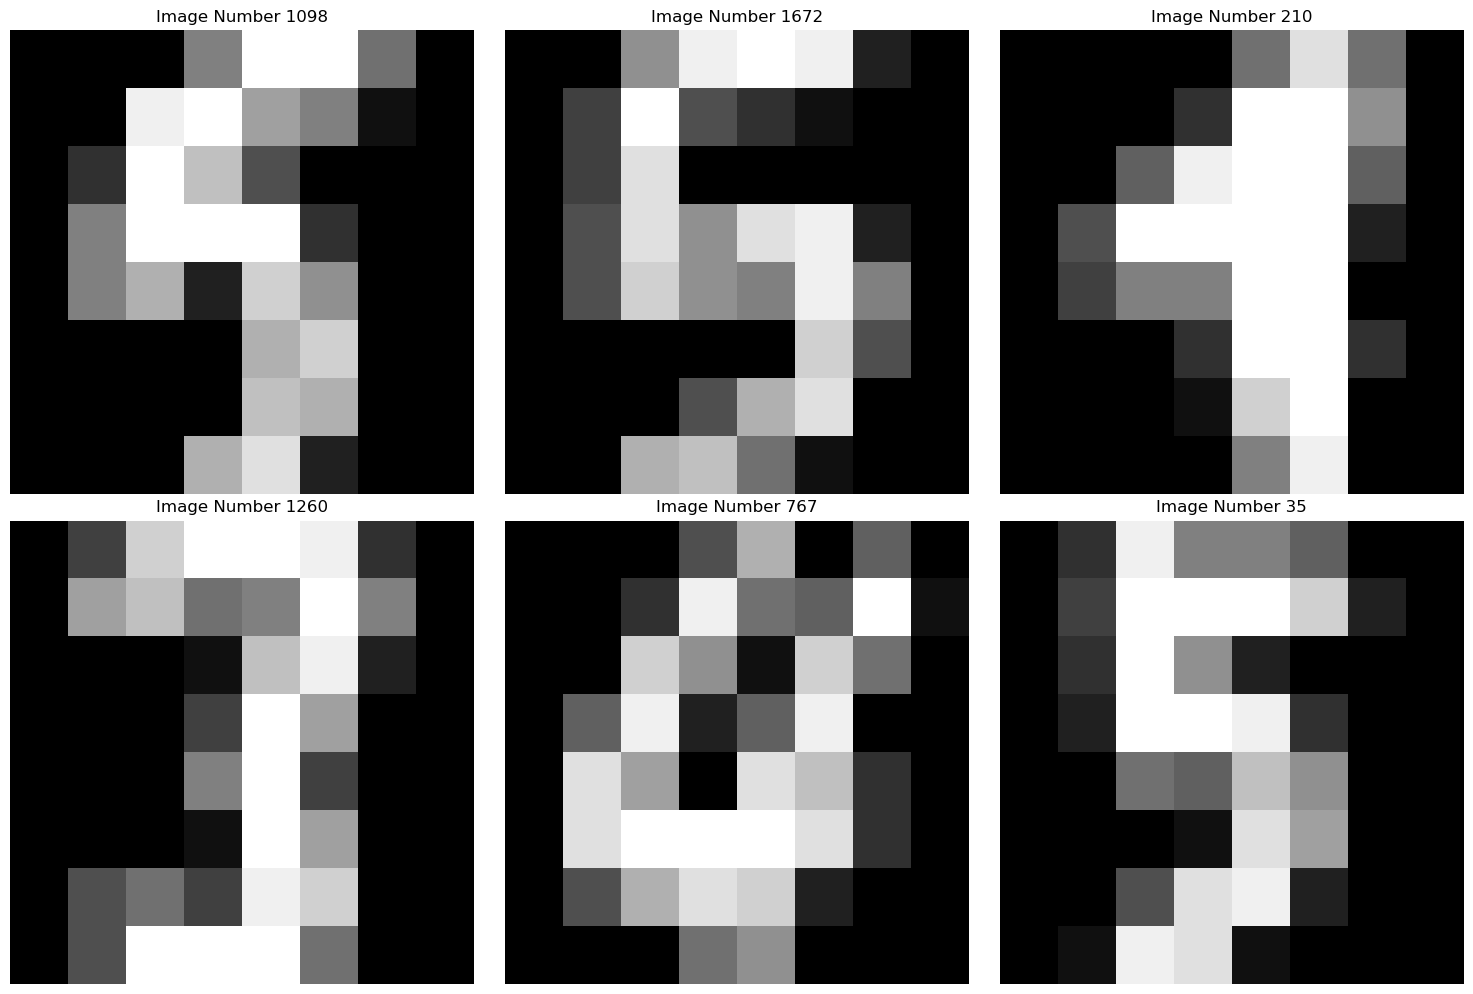

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for index, image in enumerate(random_list):
    row = index // 3
    col = index % 3
    ax[row, col].imshow(digits.images[image], cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(f'Image Number {image}')
plt.tight_layout()
plt.show()

In [7]:
for index, image in enumerate(random_list):
    print(F"Image Number {image} was a {digits.target[image]}")

Image Number 1098 was a 5
Image Number 1672 was a 5
Image Number 210 was a 1
Image Number 1260 was a 3
Image Number 767 was a 4
Image Number 35 was a 5


----
&nbsp;
### K-Means Clustering

There are 10 digits, therefore we have 10 clusters

In [8]:
model = KMeans(n_clusters=10, random_state=42)
# random_state can be any integer and ensures model is built in same way each time we run the code

In [9]:
model.fit(digits.data)

KMeans(n_clusters=10, random_state=42)

----
&nbsp;
###  Visualising after K-Means

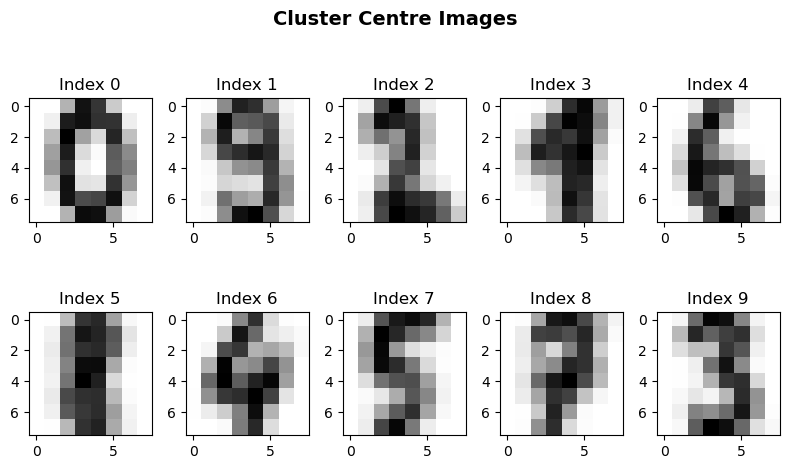

In [10]:
fig = plt.figure(figsize=(8,5))
fig.suptitle('Cluster Centre Images', fontsize=14, fontweight='bold')
for i in range(10):
    # 2x5 grid at the i+1th position
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(model.cluster_centers_[i].reshape(8,8),cmap=plt.cm.binary)
    ax.set_title(F'Index {i}')
#plt.savefig('label_map.png') # Commented out to save file as .png file
plt.tight_layout()
plt.show()

By inspection, the model will struggle with 1, 7 & 8

----
&nbsp;
### Define evaluation benchmark

The evaluation benchmark function compares different initialisation methods for KMeans.
The benchmark will,

- create a pipeline which will scale the data using a StandardScaler;
- train and time the pipeline fitting;
- measure the performance of the clustering obtained via different metrics.

In [11]:
import evaluation_benchmark as eva

In [12]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
eva.bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
eva.bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
eva.bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.095s	69662	0.680	0.719	0.699	0.570	0.695	0.192
random   	0.091s	69707	0.675	0.716	0.694	0.560	0.691	0.158
PCA-based	0.020s	72686	0.636	0.658	0.647	0.521	0.643	0.143
__________________________________________________________________________________


#### We compare three approaches

- initialization using k-means++. This method is stochastic. We will run the initialization 4 times;

- random initialization. This method is also stochastic. We will run the initialization 4 times;

- initialization based on a PCA projection. Indeed, we will use the components of the PCA to initialize KMeans. This method is deterministic and a single initialization will suffice.

----
&nbsp;
### Visualise the results on PCA-reduced data

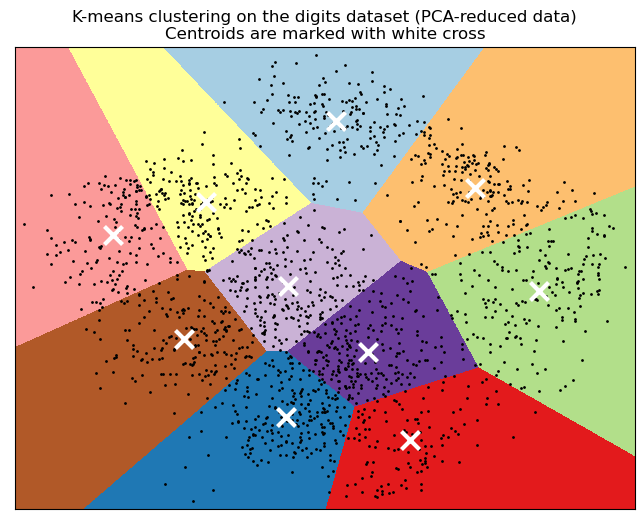

In [13]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

----
&nbsp;
### Testing the model

`test.html` and `JsCode.js` allow users to draw digits and produce arrays

## Question,
&nbsp;
### 'What year will AI take over the world?'
&nbsp;
<img alt="Robots.png" height="180" src="Images/gray.png" width="500"/>

Copied the array from `test.html`

In [24]:
gray_sample = np.array([
[0.00,0.00,0.90,8.05,11.47,9.95,0.26,0.00,0.00,2.43,11.22,9.31,2.43,12.24,2.17,0.00,1.41,11.73,6.64,0.13,1.02,12.62,1.15,0.00,1.79,5.87,0.00,0.00,5.74,9.82,0.00,0.00,0.00,0.00,0.00,2.30,12.12,3.06,0.00,0.00,0.00,0.00,3.44,11.86,6.52,0.00,0.00,0.00,0.64,7.91,12.50,6.63,2.55,2.55,3.45,0.26,9.82,12.75,12.75,11.60,10.33,10.20,9.95,1.28],
[0.00,0.77,8.68,12.50,12.10,8.29,1.02,0.00,0.13,9.82,9.18,1.28,2.29,9.95,5.61,0.00,3.95,10.97,0.38,0.00,0.00,4.59,9.95,0.00,8.29,6.25,0.00,0.00,0.00,3.95,10.20,0.00,7.40,8.55,0.00,0.00,0.00,5.99,8.29,0.00,1.28,11.10,8.16,0.38,0.64,11.10,4.72,0.00,0.00,1.02,10.07,10.07,10.20,9.44,0.38,0.00,0.00,0.00,0.38,6.64,7.53,0.77,0.00,0.00],
[0.00,0.00,0.13,10.97,3.06,0.00,0.00,0.00,0.00,0.00,4.97,10.71,0.13,0.00,0.00,0.00,0.00,0.26,11.60,3.82,0.00,0.00,0.00,0.00,0.00,4.34,10.58,0.00,0.00,0.00,0.00,0.00,0.00,9.05,9.44,6.38,6.38,5.87,1.28,0.00,0.00,10.20,12.75,7.78,6.38,10.07,7.14,0.00,0.00,6.76,10.71,0.77,0.13,9.82,6.12,0.00,0.00,0.64,9.18,10.58,9.82,10.46,0.77,0.00],
[0.00,10.08,12.37,12.75,12.75,12.50,0.51,0.00,0.00,12.24,2.68,0.00,0.00,0.00,0.00,0.00,0.00,12.75,5.23,3.70,1.79,0.00,0.00,0.00,0.00,11.23,9.57,9.69,12.37,8.04,0.26,0.00,0.00,0.00,0.00,0.00,1.66,12.11,2.30,0.00,0.90,1.15,0.00,0.26,6.26,12.37,1.53,0.00,5.36,12.24,10.71,12.11,11.10,3.20,0.00,0.00,0.13,1.66,2.55,1.79,0.00,0.00,0.00,0.00]
])

In [25]:
# Predict new labels for the digits of this ominous date
gray_labels = model.predict(gray_sample)
print(gray_labels)

[2 0 4 7]


### The label map we produced earlier

![label_map.png](Images/label_map.png)

In [26]:
label_map = {0: 0, 1: 9, 2: 2, 3: 1, 4: 6, 5: 8, 6: 4, 7: 5, 8: 7, 9: 3}

for label in new_labels:
    print(label_map[label], end='')

2065

#### The model has recognised my handwriting written in `gray`

However, the model was trained in grayscale

----
&nbsp;
### How does the model handle the colour `mint`?

<img alt="mint.png" height="179" src="Images/mint.png" width="500"/>

In [29]:
mint_sample = np.array([
[0.00,0.09,4.41,7.35,7.17,2.02,0.00,0.00,0.00,5.24,7.99,2.85,5.88,5.51,0.00,0.00,1.10,8.82,1.29,0.00,5.05,5.24,0.00,0.00,0.00,0.00,0.00,0.00,7.63,2.94,0.00,0.00,0.00,0.00,0.00,2.20,8.45,0.18,0.00,0.00,0.00,0.00,1.29,7.99,4.04,0.00,0.00,0.00,0.00,3.22,8.27,8.91,5.42,4.13,3.12,2.11,0.00,4.04,4.41,3.67,4.32,5.60,6.43,5.42],
[0.00,1.10,4.32,6.34,6.06,3.77,0.00,0.00,1.65,8.82,6.24,3.58,3.86,8.73,2.20,0.00,6.61,4.78,0.00,0.00,0.00,5.33,5.24,0.00,8.91,1.47,0.00,0.00,0.00,2.30,8.27,0.18,8.73,1.47,0.00,0.00,0.00,0.00,8.54,1.84,6.61,4.13,0.00,0.00,0.00,1.74,9.00,0.83,2.30,8.82,6.25,4.41,5.60,8.91,4.68,0.00,0.00,1.56,4.32,6.43,5.24,1.75,0.00,0.00],
[0.00,0.00,0.73,8.36,2.20,0.00,0.00,0.00,0.00,0.09,6.62,5.88,0.00,0.00,0.00,0.00,0.00,3.21,7.81,0.55,0.00,0.00,0.00,0.00,0.00,7.90,3.12,0.00,0.00,0.00,0.00,0.00,1.47,8.91,2.66,4.13,3.40,0.37,0.00,0.00,1.84,9.19,7.81,5.79,7.62,8.54,3.40,0.00,0.37,8.54,2.66,0.00,0.00,4.68,7.26,0.00,0.00,4.13,8.54,6.98,6.61,8.91,4.04,0.00],
[3.49,8.27,8.64,9.19,9.19,8.82,3.58,0.00,1.74,9.09,1.29,0.18,0.00,0.00,0.00,0.00,0.18,9.19,4.50,4.59,3.95,0.37,0.00,0.00,0.46,7.26,5.88,4.87,7.44,5.78,0.00,0.00,0.00,0.00,0.00,0.00,2.11,8.73,0.00,0.00,2.39,2.30,0.00,0.00,4.59,7.26,0.00,0.00,3.30,9.01,5.97,7.17,8.73,2.11,0.00,0.00,0.00,1.84,3.67,3.31,0.74,0.00,0.00,0.00]
])

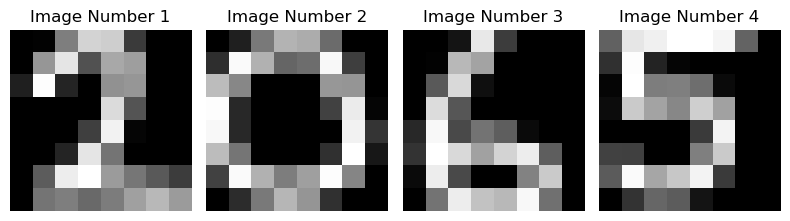

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 10))
for i in range(4):
    ax[i].imshow(mint_sample[i].reshape(8, 8), cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Image Number {i+1}')
plt.tight_layout()
plt.show()

In [30]:
mint_labels = model.predict(mint_sample)
print(mint_labels)

[2 0 4 7]


In [31]:
# Which label is which?
for label in new_new_labels:
    print(label_map[label], end='')

2065

### The model has passed with a different colour.

----

## There are numerous iterations of handwriting to test by producing a sample in `test.html`

Testing the model on;

- range of colours
- range of line thicknesses
- wonderful and bizarre hieroglyphics (that are nevertheless numbers)